### Set up coding env.

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os,glob
import peptides as pep
from Bio.Seq import Seq 
from Bio.SeqUtils import MeltingTemp as mt
from Bio import SeqIO
from Bio.SeqUtils import GC
import peptides as pep
import pickle as pk

#Load protein fasta files with Biopython 

def read_fasta(fasta_file):
    content = {}
    fas = open(fasta_file,'r')
    seq = ''
    last_entry = ''
    while True:
        line = fas.readline()
        if len(line)==0:
            content[last_entry]=seq
            break
        if '>' in line:
            if last_entry=='':
                line = line.rstrip()
                last_entry=line
            else:
                line = line.rstrip()
                content[last_entry]=seq
                last_entry=line
                seq=''
        else:
            line = line.rstrip()
            seq += line
    return content

def read_gff(gff_file, retrieve_keys = ['Locus','Name']):
    import pandas as pd
    columns=['Seqid','Source','type','Start',
             'End','Score','Strand','Phase'] + retrieve_keys
    df_raw = []
    with open(gff_file, 'r') as f:
        while True:
            line = f.readline().rstrip()
            if line == '':
                f.close()
                break
            else:
                line = line.split('\t')
                info = line[:-1]
                info_dict={}
                for x in line[-1].split(';'):
                    if x.count('=') == 1:
                        k,v = x.split('=')
                        info_dict[k] = v
                info += [info_dict[k] for k in retrieve_keys]
                df_raw.append(info)
    df = pd.DataFrame(df_raw,columns=columns)
    df[['Start','End']] = df[['Start','End']].astype(int)
    return df.sort_values(by='Start').reset_index(drop=True)


def determine_primers(gene_sequence, gibson_handle, direction):
        
    #Compute reverse complement for reverse primers and check for a stop codon        
    if direction == 'rvs':
        protein = gene_sequence.translate()
        test_stop = protein.endswith('*')
        if test_stop:
            gene_sequence = gene_sequence[0:len(gene_sequence)-3]
        gene_sequence = gene_sequence.reverse_complement()
    
    #Remove the start codon if fwd seq
    if direction == 'fwd':
        gene_sequence = gene_sequence[3:]    
        
    #Grabbing the first nucleotide to initialize a seq object
    pcr_handle = gene_sequence[0]
    
    #Extend PCR handle based on gene sequence until a melting temperature of 58 reached
    i = 1
    while mt.Tm_NN(pcr_handle, nn_table=mt.DNA_NN4)<58:
        pcr_handle = pcr_handle + gene_sequence[i]
        i = i+1
        
    #Set the minumum length of the PCR handle to 19 nucleotides
    if i < 19:
        pcr_handle = pcr_handle + gene_sequence[i:19]
        i = 19
        
    #Returns primer sequence and melting temp
    primer = gibson_handle + pcr_handle
    return(str(primer))

### Load reference data

In [55]:
#Load vulnerabilty indicies for Mtb and Msm PMID: 34297925
path = '/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Sam_cloning/Primers_and_primer_design/Reference_datasets/'
mtb_vi = pd.read_excel(path+'Vulnerability_index.xlsx', sheet_name='(1) Mtb H37Rv')
msm_vi = pd.read_excel(path+'Vulnerability_index.xlsx', sheet_name='(3) Msmeg')

#Loading ortholog reference sheet PMID: 33653882
ortho_info = pd.read_excel(path+'MSR_GENE_info.xlsx')

#Loading Mtb protein sequences with locus ID 
mtb_proteins = {k[1:].split('|')[0]:v for k,v in read_fasta(path+'Mycobacterium_tuberculosis_H37Rv_proteins_v4.fasta').items()}

#Loading Msm protein sequences with locus ID 
msm_proteins = {k[1:].split('|')[0]:v for k,v in read_fasta(path+'Mycobacterium_smegmatis_MC2-155_proteins_v4.fasta').items()}

# Fix locus tag issues
mtb_vi['Locus'] = ['Rv'+v.split('BD')[1] if 'RVBD' in v else v for v in mtb_vi['locus_tag'].values]
msm_vi['Locus'] = ['MSMEG_'+v.split('MSMEG')[1] if 'MSMEG' in v else v for v in msm_vi['locus_tag'].values]

# Load Mtb gff
mtb_gff = pd.read_table(path+'Mycobacterium_tuberculosis_H37Rv_txt_v4.txt',delimiter='\t')

# re-index VI dataframe
mtb_vi = mtb_vi.set_index('Locus')
msm_vi = msm_vi.set_index('Locus')

#Loading Msm gene sequences with locus ID 
msm_gene_seqs = {k[1:].split('|')[0]:v for k,v in read_fasta(path+'Mycobacterium_smegmatis_MC2-155_genes_v4.fasta').items()}

### Extract all conserved proteins

In [56]:
ortho_table_msr = ortho_info[pd.notna(ortho_info['rv'])].copy()[ortho_info.columns[:2]]
ortho_table_mycobrowser = []

for mtb_locus,msm_ortho in zip(mtb_gff['Locus'].values,
                               mtb_gff['Orthologues M. smegmatis'].values):
    if mtb_locus.startswith('Rv') and len(str(msm_ortho))>=10:
        for msm_locus in msm_ortho.split(','):
            if msm_locus not in ortho_table_msr['gene'].values:
                if msm_locus=='MSMEG_0250':
                    print(msm_locus)
                ortho_table_mycobrowser.append([msm_locus,mtb_locus])
ortho_table_mycobrowser = pd.DataFrame(ortho_table_mycobrowser,columns=ortho_table_msr.columns)
union_ortho_table = pd.concat([ortho_table_msr,ortho_table_mycobrowser])
print("{} orthologs found.".format(len(union_ortho_table)))

2450 orthologs found.


### Remove entries without VI values or have spurious duplicating orthologs

In [57]:
index2include = []
msm_genes = list(union_ortho_table['gene'].values)
mtb_genes = list(union_ortho_table['rv'].values)
for i,(msm_locus,mtb_locus) in enumerate(union_ortho_table[['gene','rv']].values):
    if msm_locus in msm_vi.index and mtb_locus in mtb_vi.index and msm_genes.count(msm_locus)==1 and mtb_genes.count(mtb_locus)==1:
        index2include.append(i)
union_ortho_table = union_ortho_table.iloc[index2include].reset_index(drop=True)

### Include only essential genes

In [58]:
msm_seq_list = []
mtb_seq_list = []

union_ortho_table[['Msm_VI','Msm_Ess_TnSeq','Msm_Ess_CRISPR']] = msm_vi.loc[union_ortho_table['gene'].values,['Vulnerability Index','tnseq_ess','crispr_ess']].values
union_ortho_table[['Mtb_VI','Mtb_Ess_TnSeq','Mtb_Ess_CRISPR']] = mtb_vi.loc[union_ortho_table['rv'].values,['Vulnerability Index','tnseq_ess','crispr_ess']].values

union_ortho_table_filtered = union_ortho_table[((union_ortho_table[['Msm_Ess_CRISPR','Mtb_Ess_CRISPR']].values=='Essential')*1).sum(axis=1)==2].copy().reset_index(drop=True)
print("{} orthologs are essential in both organisms.".format(len(union_ortho_table_filtered)))

354 orthologs are essential in both organisms.


### Include a few mannualy chosen proteins of interest

In [59]:
supplement = pd.DataFrame([list(union_ortho_table[union_ortho_table['gene']=='MSMEG_3858'].values[0]),
                           list(union_ortho_table[union_ortho_table['gene']=='MSMEG_1435'].values[0]),
                           ['MSMEG_2299','Rv3051c',0,'N/A','N/A',-7.52,'Essential','Essential']],
                          columns=union_ortho_table.columns)
union_ortho_table_filtered=pd.concat([union_ortho_table_filtered,supplement]).reset_index(drop=True)
print("{} orthologs found.".format(len(union_ortho_table_filtered)))

357 orthologs found.


### Add primary protein sequence information

In [60]:
union_ortho_table_filtered['Msm_seq'] = [msm_proteins[k] for k in union_ortho_table_filtered['gene'].values]
union_ortho_table_filtered['Mtb_seq'] = [mtb_proteins[k] for k in union_ortho_table_filtered['rv'].values]
union_ortho_table_filtered['Msm_seq_N20'] = [msm_proteins[k][:20] for k in union_ortho_table_filtered['gene'].values]
union_ortho_table_filtered['Mtb_seq_N20'] = [mtb_proteins[k][:20] for k in union_ortho_table_filtered['rv'].values]
union_ortho_table_filtered['Msm_seq_C20'] = [msm_proteins[k][-20:] for k in union_ortho_table_filtered['gene'].values]
union_ortho_table_filtered['Mtb_seq_C20'] = [mtb_proteins[k][-20:] for k in union_ortho_table_filtered['rv'].values]
union_ortho_table_filtered['Msm_pro_length'] = [len(msm_proteins[k]) for k in union_ortho_table_filtered['gene'].values]
union_ortho_table_filtered['Mtb_pro_length'] = [len(mtb_proteins[k]) for k in union_ortho_table_filtered['rv'].values]

### Add simple protein features

In [61]:
union_ortho_table_filtered['Msm_PI'] = [pep.Peptide(x).isoelectric_point() for x in union_ortho_table_filtered['Msm_seq'].values]
union_ortho_table_filtered['Mtb_PI'] = [pep.Peptide(x).isoelectric_point() for x in union_ortho_table_filtered['Mtb_seq'].values]
union_ortho_table_filtered['Msm_Aliphatic_Index'] = [pep.Peptide(x).aliphatic_index() for x in union_ortho_table_filtered['Msm_seq'].values]
union_ortho_table_filtered['Mtb_Aliphatic_Index'] = [pep.Peptide(x).aliphatic_index() for x in union_ortho_table_filtered['Mtb_seq'].values]
union_ortho_table_filtered['PI_difference'] = np.abs(union_ortho_table_filtered['Msm_PI'].values-union_ortho_table_filtered['Mtb_PI'].values)
union_ortho_table_filtered['Aliphatic_Index_difference'] =np.abs(union_ortho_table_filtered['Msm_Aliphatic_Index'].values-union_ortho_table_filtered['Mtb_Aliphatic_Index'].values)

### Exclude proteins that are too large or too small

In [63]:
union_ortho_table_filtered = union_ortho_table_filtered[(union_ortho_table_filtered['Msm_pro_length']<1500)&\
                                                        (union_ortho_table_filtered['Msm_pro_length']<1500)&\
                                                        (union_ortho_table_filtered['Msm_pro_length']>100)&\
                                                        (union_ortho_table_filtered['Msm_pro_length']>100)].copy()
print("Found {} orthologs whose lengths are between 100 and 1500".format(len(union_ortho_table_filtered)))

Found 348 orthologs whose lengths are between 100 and 1500


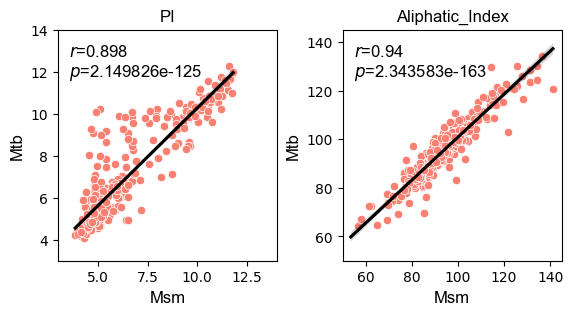

In [64]:
# plot protein feature correslation between Msm and Mtb homologs
from scipy.stats import pearsonr

fig,axes=plt.subplots(figsize=(6.5,3),ncols=2,gridspec_kw={'wspace':0.3})
sns.scatterplot(data=union_ortho_table_filtered,x='Msm_PI',y='Mtb_PI',ax=axes[0],color='salmon')
sns.scatterplot(data=union_ortho_table_filtered,x='Msm_Aliphatic_Index',y='Mtb_Aliphatic_Index',ax=axes[1],color='salmon')
sns.regplot(data=union_ortho_table_filtered,x='Msm_PI',y='Mtb_PI',ax=axes[0],scatter=False,color='black')
sns.regplot(data=union_ortho_table_filtered,x='Msm_Aliphatic_Index',y='Mtb_Aliphatic_Index',ax=axes[1],scatter=False,color='black')
axes[0].set_xlabel('Msm',fontsize=12,fontname='Arial')
axes[0].set_ylabel('Mtb',fontsize=12,fontname='Arial')
axes[0].set_title('PI',fontsize=12,fontname='Arial')
axes[1].set_xlabel('Msm',fontsize=12,fontname='Arial')
axes[1].set_ylabel('Mtb',fontsize=12,fontname='Arial')
axes[1].set_title('Aliphatic_Index',fontsize=12,fontname='Arial')
axes[0].set_xlim(3,14)
axes[0].set_ylim(3,14)
axes[1].set_xlim(50,145)
axes[1].set_ylim(50,145)

r1,p1 = pearsonr(union_ortho_table_filtered['Msm_PI'],union_ortho_table_filtered['Mtb_PI'])
r2,p2 = pearsonr(union_ortho_table_filtered['Msm_Aliphatic_Index'],union_ortho_table_filtered['Mtb_Aliphatic_Index'])
axes[0].text(0.05,0.8,'$r$={}\n$p$={:e}'.format(round(r1,3),p1),transform=axes[0].transAxes,fontsize=12,fontname='Arial',ha='left')
axes[1].text(0.05,0.8,'$r$={}\n$p$={:e}'.format(round(r2,3),p2),transform=axes[1].transAxes,fontsize=12,fontname='Arial',ha='left')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_Union_ortho_feature_corr.svg',
            bbox_inches='tight')

### Save data

In [65]:
union_ortho_table_filtered.to_csv('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/union_ortho_table_filtered.csv')